In [1]:
import numpy as np
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.transforms as transforms
import subprocess
import astropy.units as u
from synphot import SpectralElement, Empirical1D, SourceSpectrum, Observation

from model_W0116_spec import model_W0116_spec
from polModel import PolModel

import os
gd_folder = os.getcwd()+"/../Calculations/Gas_and_dust/"

import sys 
sys.path.append(gd_folder)
from polWaveDust import PolWaveDust
from polWaveGas import PolWaveGas

sys.path.append("../plots/utility_functions/")
from objectProperties import ObjectProperties
from readExtrapolatedSpectra import ReadExtrapolatedSpectra

sys.path.append("../Filter_Curves/")
from readBands import ReadBands

In [2]:
#Load the properties of the BHDs
wid = "W0116-0505"
op = ObjectProperties([wid])

In [3]:
#Load the bands.
bands = ReadBands()
for bname in bands.bandnames:
    print(bname, bands.bp[bname].barlam(), bands.bp[bname].fwhm(), bands.bp[bname].rectwidth())

R_SPECIAL 6501.229535920617 Angstrom 1159.881393925198 Angstrom 1624.9974574790472 Angstrom
I_BESS 7925.773360798338 Angstrom 1080.5202412457434 Angstrom 1433.1539789444323 Angstrom
v_HIGH 5531.691038305597 Angstrom 850.6231300284223 Angstrom 1195.0838113345558 Angstrom


In [4]:
#Load the spectra for each BHD, extended using the best-fit SED, although here we will not care about the extension.
specs = ReadExtrapolatedSpectra()

Wavelength range for object W0019-1046 limited because of sky template
Spec-range: 3001.5 Angstrom - 5423.93 Angstrom
Sky-range: 3199.4 Angstrom - 6724.06 Angstrom
Wavelength range for object W0204-0506 limited because of sky template
Spec-range: 3786.2 Angstrom - 6672.70 Angstrom
Sky-range: 3789.3 Angstrom - 6682.76 Angstrom
Warning, 2 of 3161 bins contained negative fluxes; they have been set to zero.
Wavelength range for object W0831+0140 limited because of sky template
Spec-range: 3786.2 Angstrom - 6672.45 Angstrom
Sky-range: 3789.3 Angstrom - 6682.76 Angstrom
Warning, 2 of 3161 bins contained negative fluxes; they have been set to zero.


## Spectrum, spectrum model and general pol model object

In [5]:
#Load the spectrum. 
spec, spec_model = model_W0116_spec(specs)

In [6]:
full_spec = SourceSpectrum(Empirical1D, points=spec.lam_obs, lookup_table=spec.flam, keep_neg=True)

In [7]:
pol_model = PolModel(spec, spec_model, bands, op)

In [8]:
#Dictionaries to save the results.
xopt_all  = dict()
mod_p_all = dict() 

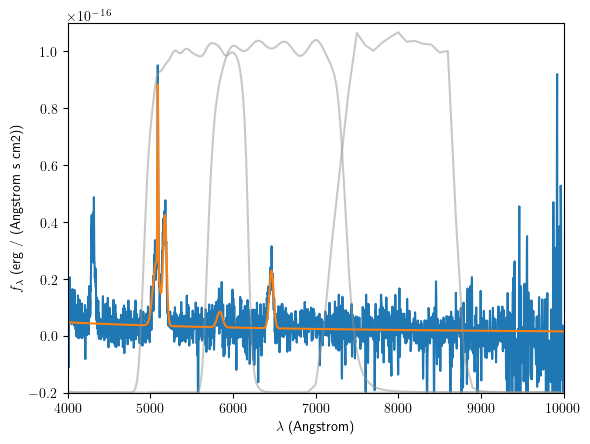

In [9]:
#Plot the spectrum, the best-fit model, and the filter curves.
pol_model.spec_plot()

(-5e-17, 5e-17)

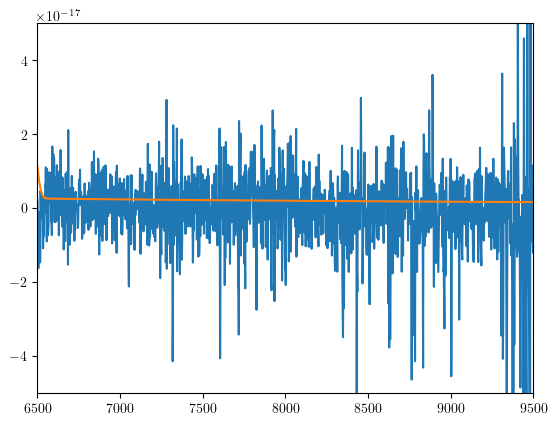

In [10]:
plt.plot(spec.lam_obs, spec.flam-spec_model.flam_model(spec.lam_rest))
plt.plot(spec.lam_obs, spec_model.flam_model(spec.lam_rest))
plt.xlim([6500, 9500])
plt.ylim([-5e-17, 5e-17])

In [41]:
#General plotting function
def pol_plot(mod_p, spec, pol_model, fmt="ko", show_legend=True):

    # data = np.loadtxt("pol_measurements.dat", usecols=[1,2])
    # p_measured = data[:,0]
    # p_unc = data[:,1]
    p_measured =pol_model.p_measured
    p_unc = pol_model.p_unc

    wave = np.array([5500., 6500., 8000.]) / spec.zspec

    fig, ax = plt.subplots(1)

    #ax.errorbar(wave, p_measured, yerr=p_unc, fmt='ko', label='Measurements')
    ax.errorbar(wave, p_measured, yerr=p_unc, fmt=fmt, label='Measurements')
    for scat_type in mod_p.keys():
        if scat_type[-3:]=="LMC":
            fmt = '^'
        elif scat_type[-3:]=="SMC":
            fmt = 's'
        elif scat_type[-2:]=="MW":
            fmt = 'P'
        else:
            fmt='p'

        ax.plot(wave, mod_p[scat_type], fmt, label=scat_type)

    if show_legend:
        ax.legend(ncol=3)
    ax.set_xlabel('Wavelength (Angstroms)')
    ax.set_ylabel('Polarization fraction')
    plt.show()

## Pure Gas Polarization

#### Same inclination for Continuum and Lines

In [12]:
#Define the scattering object
class Gas_Gas(object):

    def __init__(self):

        #Set the number of parameters for the continuum (a) and the lines (b). The order in x is always: delta_chi, a model parameters, b model parameters (if any).
        self.npar_a = 2

        #Load the simple gas model. 
        self.gas_obj = PolWaveGas()

        return

    #In this model, the continuum and emission line polarization fraction is forced to be the same. 
    def pfrac(self, x, lam):
        a_pars = x[1:self.npar_a+1]
        theta = a_pars[0]
        psi = a_pars[1]
        return self.gas_obj.p(([theta],[psi])).flatten()[0] * np.ones(len(lam))
    
    #Continuum polarization fraction    
    def pfrac_A(self, x, lam):
        return self.pfrac(x, lam)

    #Line polarization fraction    
    def pfrac_B(self, x, lam):
        return self.pfrac(x, lam)

In [13]:
scat_obj = Gas_Gas()

##### Force the same polarization angle. 

In [14]:
x0 = np.array([0., 80., 50.])
min_vals = np.array([0., 0., 0.])
max_vals = np.array([0., 90., 90.])
pol_model.fit_pol(scat_obj, x0, min_vals, max_vals, method='trust-constr')
#pol_model.fit_pol(scat_obj, x0, min_vals, max_vals, method='BFGS')

mname = "GG0"
xopt_all[mname]  = pol_model.xopt
mod_p_all[mname] = pol_model.mod_p

`xtol` termination condition is satisfied.
[-1.78460011e-23  7.47087727e+01  7.47691856e+01]
49.76936048766014


##### Allow for different polarization angles.

In [15]:
x0 = np.array([0., 80., 50.])
min_vals = np.array([0., 0., 0.])
max_vals = np.array([90., 90., 90.])
pol_model.fit_pol(scat_obj, x0, min_vals, max_vals, method='trust-constr')
#pol_model.fit_pol(scat_obj, x0, min_vals, max_vals, method='BFGS')

mname = "GG1"
xopt_all[mname]  = pol_model.xopt
mod_p_all[mname] = pol_model.mod_p

`xtol` termination condition is satisfied.
[38.73561987 67.64692592 71.30071897]
23.58296001307344


In [16]:
x0 = np.array([40., 60., 70.])
min_vals = np.array([0., 0., 0.])
max_vals = np.array([90., 90., 90.])
pol_model.fit_pol(scat_obj, x0, min_vals, max_vals, method='trust-constr')
#pol_model.fit_pol(scat_obj, x0, min_vals, max_vals, method='BFGS')

mname = "GG1"
xopt_all[mname]  = pol_model.xopt
mod_p_all[mname] = pol_model.mod_p

`xtol` termination condition is satisfied.
[38.73561029 60.34551612 69.0136586 ]
23.582960013065527


#### Allow for independent torus opening angles for lines and continuum.

I *believe* that a scatterer very near the accretion disk should be able to be modeled by allowing for different opening angles, which in that model would just simply become for the lines the size of the BLR ring shining into a small scatterer, and for the continuum it would become the covering angle by the scatterer.

In [17]:
#Define the scattering object
class Gas_Gas(object):

    def __init__(self):

        #Set the number of parameters for the continuum (a) and the lines (b). The order in x is always: delta_chi, a model parameters, b model parameters (if any).
        self.npar_a = 2
        self.npar_b = 1

        #Load the simple gas model. 
        self.gas_obj = PolWaveGas()

        return

    #In this model, the continuum and emission line polarization fraction is forced to be the same. 
    def pfrac_A(self, x, lam):
        a_pars = x[1:self.npar_a+1]
        theta = a_pars[0]
        psi_A = a_pars[1]
        return self.gas_obj.p(([theta],[psi_A])).flatten()[0] * np.ones(len(lam))
    
    #Emission line polarization.
    def pfrac_B(self, x, lam):
        a_pars = x[1:self.npar_a+1]
        theta = a_pars[0]
        b_pars = x[self.npar_a+1:]
        psi_B = b_pars[0]
        return self.gas_obj.p(([theta],[psi_B])).flatten()[0] * np.ones(len(lam))
    

In [18]:
scat_obj = Gas_Gas()

In [19]:
x0 = np.array([0., 80., 50., 50.])
min_vals = np.array([0., 0., 0., 0.])
max_vals = np.array([90., 90., 90., 90.])
pol_model.fit_pol(scat_obj, x0, min_vals, max_vals, method='trust-constr')
#pol_model.fit_pol(scat_obj, x0, min_vals, max_vals, method='BFGS')

mname = "GG2"
xopt_all[mname]  = pol_model.xopt
mod_p_all[mname] = pol_model.mod_p

`xtol` termination condition is satisfied.
[60.39298673 63.27314761 69.70805571 40.83088673]
1.6749139209982878e-12


Now, force the polarization angle to be the same, as suggested by the edge on view of Zakamska & Alexandroff (2023).

In [20]:
x0 = np.array([0., 80., 30., 70.])
min_vals = np.array([0., 0., 0., 0.])
max_vals = np.array([0., 90., 90., 90.])
pol_model.fit_pol(scat_obj, x0, min_vals, max_vals, method='trust-constr')
#pol_model.fit_pol(scat_obj, x0, min_vals, max_vals, method='BFGS')

mname = "GG3"
xopt_all[mname]  = pol_model.xopt
mod_p_all[mname] = pol_model.mod_p

`xtol` termination condition is satisfied.
[-4.62045327e-25  5.66271251e+01  6.77010467e+01  7.85149150e+01]
28.878026834005198


In [21]:
x0 = np.array([0., 90., 30., 70.])
min_vals = np.array([0., 90., 0., 0.])
max_vals = np.array([90., 90., 90., 90.])
pol_model.fit_pol(scat_obj, x0, min_vals, max_vals, method='trust-constr')
#pol_model.fit_pol(scat_obj, x0, min_vals, max_vals, method='BFGS')

mname = "GG4"
xopt_all[mname]  = pol_model.xopt
mod_p_all[mname] = pol_model.mod_p

`gtol` termination condition is satisfied.
[60.39298892 90.         73.5277995  52.03925586]
2.3286012784002474e-12


In [22]:
scat_obj.pfrac_A(pol_model.xopt.x, [1]), scat_obj.pfrac_B(pol_model.xopt.x, [1])

(array([0.14301757]), array([0.42539088]))

In [23]:
pol_model.mod_p

<Quantity [0.0959    , 0.1109    , 0.14300001]>

## Pure dust polarization

In [24]:
dust_types = ["SMC", "LMC", "MW"]

#### Require the same polarization for the continuum and the emission lines.

In [25]:
#Define the scattering object
class Dust_Dust(object):

    def __init__(self, dust_type, fw=True, bw=True):

        #Save the input parameters.
        self.dust_type = dust_type
        self.fw = fw
        self.bw = bw

        #Set the number of parameters for the continuum (a) and the lines (b). The order in x is always: delta_chi, a model parameters, b model parameters (if any).
        self.npar_a = 2

        #Load the simple gas model. 
        self.dust_obj = PolWaveDust(self.dust_type, fw=self.fw, bw=self.bw)

        return

    #In this model, the continuum and emission line polarization fraction is forced to be the same. 
    def pfrac(self, x, lam):
        a_pars = x[1:self.npar_a+1]
        theta = a_pars[0] * np.ones(len(lam))
        psi = a_pars[1] * np.ones(len(lam))
        return self.dust_obj.p((lam.to(u.AA).value, theta, psi)).flatten()
    
    #Continuum polarization fraction    
    def pfrac_A(self, x, lam):
        return self.pfrac(x, lam)

    #Line polarization fraction    
    def pfrac_B(self, x, lam):
        return self.pfrac(x, lam)

##### Force the same polarization angle. 

In [26]:
for dust_type in dust_types:
    print(dust_type)

    x0 = np.array([0., 80., 45.])
    min_vals = np.array([0., 0., 0.])
    max_vals = np.array([0., 90., 90.])

    #Consider forward+backward, forward and backward only options.
    for i in range(3):
        suffix = ""
        if i==0:
            fw=True
            bw=True
            suffix="FWBW"
        elif i==1:
            fw=True
            bw=False
            suffix="FW"
        else:
            fw=False
            bw=True
            suffix="BW"
        print(suffix)
        scat_obj = Dust_Dust(dust_type, fw=fw, bw=bw)
        pol_model.fit_pol(scat_obj, x0, min_vals, max_vals, method='trust-constr')
        #pol_model.fit_pol(scat_obj, x0, min_vals, max_vals, method='BFGS')

        mname = "DD0_"+suffix+"_"+dust_type
        if mname not in xopt_all or pol_model.xopt.fun < xopt_all[mname].fun:
            xopt_all[mname]  = pol_model.xopt
            mod_p_all[mname] = pol_model.mod_p

    print()

SMC
FWBW
`xtol` termination condition is satisfied.
[-2.24283076e-24  6.44416140e+01  4.94281681e+01]
599.2987641894713
FW
`xtol` termination condition is satisfied.
[-9.67459753e-23  5.68297715e+01  3.73544814e+01]
566.3239521123065
BW
`xtol` termination condition is satisfied.
[7.25203295e-25 5.97379233e+01 6.34999996e+01]
583.1326707185477

LMC
FWBW
`xtol` termination condition is satisfied.
[9.31517577e-25 6.45804614e+01 5.00194618e+01]
819.6371431817201
FW
`xtol` termination condition is satisfied.
[8.00146212e-23 4.42602212e+01 2.35965488e+01]
736.0976661343183
BW
`xtol` termination condition is satisfied.
[-6.84225360e-25  6.84999994e+01  6.62580871e+01]
796.6731026146268

MW
FWBW
`xtol` termination condition is satisfied.
[1.70764810e-26 3.67296690e+01 6.11419154e+00]
444.98967232648266
FW
`xtol` termination condition is satisfied.
[-3.00491731e-26  3.95616112e+01  1.33197600e+01]
351.6222323604536
BW
`gtol` termination condition is satisfied.
[8.71546323e-20 9.00000000e+01 6.0

##### Allow for different polarization angles. 

In [27]:
for dust_type in dust_types:
    print(dust_type)

    x0 = np.array([0., 80., 45.])
    min_vals = np.array([0., 0., 0.])
    max_vals = np.array([90., 90., 90.])

    #Consider forward+backward, forward and backward only options.
    for i in range(3):
        suffix = ""
        if i==0:
            fw=True
            bw=True
            suffix="FWBW"
        elif i==1:
            fw=True
            bw=False
            suffix="FW"
        else:
            fw=False
            bw=True
            suffix="BW"
        print(suffix)
        scat_obj = Dust_Dust(dust_type, fw=fw, bw=bw)
        pol_model.fit_pol(scat_obj, x0, min_vals, max_vals, method='trust-constr')
        #pol_model.fit_pol(scat_obj, x0, min_vals, max_vals, method='BFGS')

        mname = "DD1_"+suffix+"_"+dust_type
        if mname not in xopt_all or pol_model.xopt.fun < xopt_all[mname].fun:
            xopt_all[mname]  = pol_model.xopt
            mod_p_all[mname] = pol_model.mod_p

    print()

SMC
FWBW
`xtol` termination condition is satisfied.
[89.99901794 89.9999998  19.85960488]
85.7271344206234
FW
`xtol` termination condition is satisfied.
[89.78168005 78.49999998  5.11213739]
73.5065452463983
BW
`xtol` termination condition is satisfied.
[89.99965719 89.99999995 19.83161654]
85.28593009980831

LMC
FWBW
`xtol` termination condition is satisfied.
[89.88670268 89.99834671 15.99999992]
389.06285686363844
FW
`xtol` termination condition is satisfied.
[7.44904000e+01 6.13978425e+01 1.73893429e-07]
345.6543974025765
BW
`xtol` termination condition is satisfied.
[89.92759825 89.99707856 15.99999998]
387.5095257867561

MW
FWBW
`xtol` termination condition is satisfied.
[82.9557124  78.49999898  0.12301259]
91.57357820215647
FW
`xtol` termination condition is satisfied.
[7.08042800e+01 5.89268379e+01 5.77813337e-08]
60.26826306190895
BW
`xtol` termination condition is satisfied.
[82.44108268 89.99651319 15.99999989]
117.23537028578082



Now, force the polarization angle to be the same between lines and gas, but allow for the polarization fraction (opening angle) to be different. 

In [30]:
#Define the scattering object
class Dust_Dust(object):

    def __init__(self, dust_type, fw=True, bw=True):

        #Save the input parameters.
        self.dust_type = dust_type
        self.fw = fw
        self.bw = bw

        #Set the number of parameters for the continuum (a) and the lines (b). The order in x is always: delta_chi, a model parameters, b model parameters (if any).
        self.npar_a = 2

        #Load the simple gas model. 
        self.dust_obj = PolWaveDust(self.dust_type, fw=self.fw, bw=self.bw)

        return

    #In this model, the continuum and emission line polarization fraction is forced to be the same. 
    def pfrac_A(self, x, lam):
        a_pars = x[1:self.npar_a+1]
        theta = a_pars[0] * np.ones(len(lam))
        psi_A = a_pars[1] * np.ones(len(lam))
        return self.dust_obj.p((lam.to(u.AA).value, theta, psi_A)).flatten()

    #Line polarization fraction    
    def pfrac_B(self, x, lam):
        a_pars = x[1:self.npar_a+1]
        theta = a_pars[0] * np.ones(len(lam))
        b_pars = x[self.npar_a+1:]
        psi_B = b_pars[0]
        return self.dust_obj.p((lam.to(u.AA).value, theta, psi_B)).flatten()

In [31]:
for dust_type in dust_types:
    print(dust_type)

    x0 = np.array([0., 80., 45., 45.])
    min_vals = np.array([0., 0., 0., 0.])
    max_vals = np.array([0., 90., 90., 90.])

    #Consider forward+backward, forward and backward only options.
    for i in range(3):
        suffix = ""
        if i==0:
            fw=True
            bw=True
            suffix="FWBW"
        elif i==1:
            fw=True
            bw=False
            suffix="FW"
        else:
            fw=False
            bw=True
            suffix="BW"
        print(suffix)
        scat_obj = Dust_Dust(dust_type, fw=fw, bw=bw)
        pol_model.fit_pol(scat_obj, x0, min_vals, max_vals, method='trust-constr')
        #pol_model.fit_pol(scat_obj, x0, min_vals, max_vals, method='BFGS')

        mname = "DD2_"+suffix+"_"+dust_type
        if mname not in xopt_all or pol_model.xopt.fun < xopt_all[mname].fun:
            xopt_all[mname]  = pol_model.xopt
            mod_p_all[mname] = pol_model.mod_p

    print()

SMC
FWBW
`xtol` termination condition is satisfied.
[1.00495480e-24 7.21863464e+01 4.38795848e+01 8.98778267e+01]
409.5951898094156
FW
`xtol` termination condition is satisfied.
[-6.37219782e-24  4.98909122e+01  1.39173430e-01  7.66866943e+01]
323.6679875152268
BW
`xtol` termination condition is satisfied.
[-2.11817334e-25  8.99994615e+01  5.04891530e+01  8.97664430e+01]
415.0384567390851

LMC
FWBW
`xtol` termination condition is satisfied.
[-8.77218508e-22  7.10194292e+01  4.39367324e+01  8.98920451e+01]
687.6245622540066
FW
`xtol` termination condition is satisfied.
[-1.20667809e-22  4.68597160e+01  6.68690940e-02  7.42481178e+01]
478.77155932626874
BW
`xtol` termination condition is satisfied.
[8.15011763e-24 8.99972601e+01 5.15657999e+01 8.96997433e+01]
692.674715960695

MW
FWBW
`xtol` termination condition is satisfied.
[7.03526754e-24 4.61829834e+01 2.65213700e-03 8.99449648e+01]
269.5545810786503
FW
The maximum number of function evaluations is exceeded.
[2.12373466e-24 4.701427

## Gas and Dust polarization 

##### Require the same inclination

In [32]:
#Define the scattering object
class Gas_Dust(object):

    def __init__(self, dust_type, fw=True, bw=True):

        #Save the input parameters.
        self.dust_type = dust_type
        self.fw = fw
        self.bw = bw

        #Set the number of parameters for the continuum (a) and the lines (b). The order in x is always: delta_chi, a model parameters, b model parameters (if any).
        self.npar_a = 2
        self.npar_b = 1

        #Load the simple gas model. 
        self.dust_obj = PolWaveDust(self.dust_type, fw=self.fw, bw=self.bw)
        self.gas_obj = PolWaveGas(fw=self.fw, bw=self.bw)

        return

    #Continuum polarization
    def pfrac_A(self, x, lam):
        a_pars = x[1:self.npar_a+1]
        theta = a_pars[0] * np.ones(len(lam))
        psi_A = a_pars[1] * np.ones(len(lam))
        return self.dust_obj.p((lam.to(u.AA).value, theta, psi_A)).flatten()
    
    #Lines polarization.
    def pfrac_B(self, x, lam):
        a_pars = x[1:self.npar_a+1]
        theta = a_pars[0] * np.ones(len(lam))
        b_pars = x[self.npar_a+1:]
        psi_B = b_pars[0] * np.ones(len(lam))
        return self.dust_obj.p((lam.to(u.AA).value, theta, psi_B)).flatten()
    

In [33]:
for dust_type in dust_types:
    print(dust_type)

    x0 = np.array([0., 80., 45., 45.])
    min_vals = np.array([0., 0., 0., 0.])
    max_vals = np.array([90., 90., 90., 90.])

    #Consider forward+backward, forward and backward only options.
    for i in range(3):
        suffix = ""
        if i==0:
            fw=True
            bw=True
            suffix="FWBW"
        elif i==1:
            fw=True
            bw=False
            suffix="FW"
        else:
            fw=False
            bw=True
            suffix="BW"
        print(suffix)
        scat_obj = Gas_Dust(dust_type, fw=fw, bw=bw)
        pol_model.fit_pol(scat_obj, x0, min_vals, max_vals, method='trust-constr')
        #pol_model.fit_pol(scat_obj, x0, min_vals, max_vals, method='BFGS')

        mname = "DG1_"+suffix+"_"+dust_type
        if mname not in xopt_all or pol_model.xopt.fun < xopt_all[mname].fun:
            xopt_all[mname]  = pol_model.xopt
            mod_p_all[mname] = pol_model.mod_p

    print()

SMC
FWBW
`xtol` termination condition is satisfied.
[ 3.22606512 72.20988453 43.89557867 89.87771924]
409.5951319619451
FW
`xtol` termination condition is satisfied.
[9.90493042e+00 4.98940485e+01 4.86517979e-02 7.66874260e+01]
323.6258621537382
BW
`xtol` termination condition is satisfied.
[ 4.27259957 89.99222029 50.49364477 89.76936115]
415.0615360875075

LMC
FWBW
`xtol` termination condition is satisfied.
[ 2.40144412 71.02896489 43.9403112  89.89197595]
687.6247621098706
FW
`xtol` termination condition is satisfied.
[ 1.66103909 46.86063743  0.10005298 74.248342  ]
478.7814191039075
BW
`xtol` termination condition is satisfied.
[ 6.01574548 89.99995205 51.56206455 89.69844865]
692.6586483044911

MW
FWBW
`xtol` termination condition is satisfied.
[4.55503257e+00 4.61828932e+01 3.15419055e-03 8.99449649e+01]
269.55472645857424
FW
`xtol` termination condition is satisfied.
[20.60226188 47.0189513   0.07665222 72.00052793]
139.06635228997408
BW
`xtol` termination condition is satisfie

##### Allow for different inclinations

In [34]:
#Define the scattering object
class Gas_Dust(object):

    def __init__(self, dust_type, fw=True, bw=True):

        #Save the input parameters.
        self.dust_type = dust_type
        self.fw = fw
        self.bw = bw

        #Set the number of parameters for the continuum (a) and the lines (b). The order in x is always: delta_chi, a model parameters, b model parameters (if any).
        self.npar_a = 2
        self.npar_b = 2

        #Load the simple gas model. 
        self.dust_obj = PolWaveDust(self.dust_type, fw=self.fw, bw=self.bw)
        self.gas_obj = PolWaveGas(fw=self.fw, bw=self.bw)

        return

    #Continuum polarization
    def pfrac_A(self, x, lam):
        a_pars = x[1:self.npar_a+1]
        theta_A = a_pars[0] * np.ones(len(lam))
        psi_A   = a_pars[1] * np.ones(len(lam))
        return self.dust_obj.p((lam.to(u.AA).value, theta_A, psi_A)).flatten()
    
    #Lines polarization.
    def pfrac_B(self, x, lam):
        b_pars = x[self.npar_a+1:]
        theta_B = b_pars[0] * np.ones(len(lam))
        psi_B   = b_pars[1] * np.ones(len(lam))
        return self.dust_obj.p((lam.to(u.AA).value, theta_B, psi_B)).flatten()
    

In [35]:
for dust_type in dust_types:
    print(dust_type)

    x0 = np.array([0., 80., 45., 80., 45.])
    min_vals = np.array([0., 0., 0., 0., 0.])
    max_vals = np.array([90., 90., 90., 90., 90.])

    #Consider forward+backward, forward and backward only options.
    for i in range(3):
        suffix = ""
        if i==0:
            fw=True
            bw=True
            suffix="FWBW"
        elif i==1:
            fw=True
            bw=False
            suffix="FW"
        else:
            fw=False
            bw=True
            suffix="BW"
        print(suffix)
        scat_obj = Gas_Dust(dust_type, fw=fw, bw=bw)
        pol_model.fit_pol(scat_obj, x0, min_vals, max_vals, method='trust-constr')
        #pol_model.fit_pol(scat_obj, x0, min_vals, max_vals, method='BFGS')

        mname = "DG2_"+suffix+"_"+dust_type
        if mname not in xopt_all or pol_model.xopt.fun < xopt_all[mname].fun:
            xopt_all[mname]  = pol_model.xopt
            mod_p_all[mname] = pol_model.mod_p

    print()

SMC
FWBW
`xtol` termination condition is satisfied.
[ 3.6359652  72.20989258 43.89649144 54.67475131 89.92476107]
409.5935117146227
FW
`xtol` termination condition is satisfied.
[ 8.55443057 49.89312625  0.20094663 50.02500219 76.71776904]
323.6552140019253
BW
`xtol` termination condition is satisfied.
[ 3.04638452 89.99573825 50.48818226 89.72552401 89.87615755]
415.0197583294856

LMC
FWBW
`xtol` termination condition is satisfied.
[ 3.51891108 71.00000001 43.921084   50.40663864 89.93628292]
687.6239648894347
FW
`xtol` termination condition is satisfied.
[3.45769515e+00 4.68707185e+01 5.73965024e-02 3.89237835e+01
 7.26086301e+01]
478.7057998292998
BW
`xtol` termination condition is satisfied.
[ 5.94933636 89.99976842 51.5578085  89.56491015 89.90553783]
692.6527983180601

MW
FWBW
`xtol` termination condition is satisfied.
[2.77911350e+00 4.61830975e+01 6.98612390e-03 5.38315912e+01
 8.99317810e+01]
269.55570747274436
FW
`xtol` termination condition is satisfied.
[8.25872393e+00 4.70

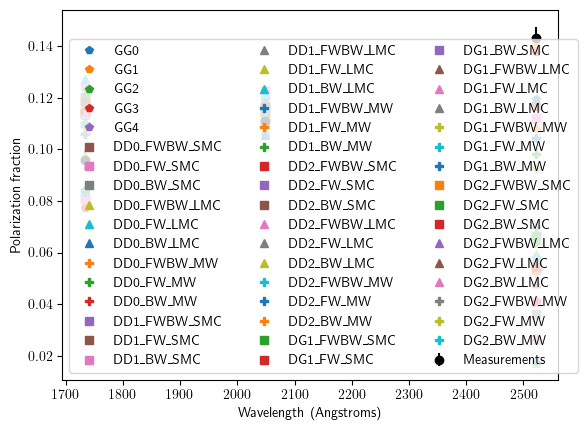

In [42]:
pol_plot(mod_p_all, spec, pol_model)

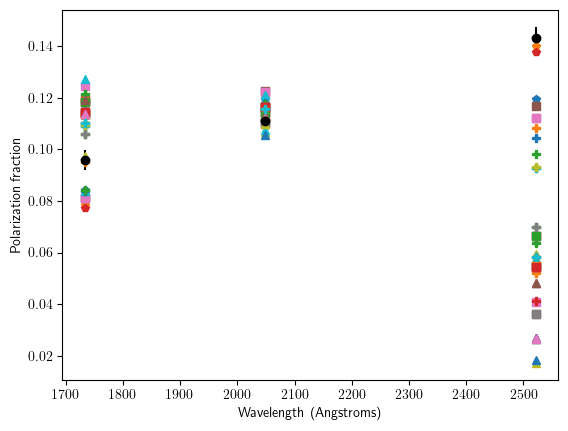

In [44]:
pol_plot(mod_p_all, spec, pol_model, show_legend=False)

In [45]:
#Rank solutions from best to worse. 
model_names = list(xopt_all.keys())
fun_all = np.zeros(len(model_names))
for i, mname in enumerate(model_names):
    fun_all[i] = xopt_all[mname].fun
k = np.argsort(fun_all)
for kk in k:
    mname = model_names[kk]
    print(mname, xopt_all[mname].fun, xopt_all[mname].x)

GG2 1.6749139209982878e-12 [60.39298673 63.27314761 69.70805571 40.83088673]
GG4 2.3286012784002474e-12 [60.39298892 90.         73.5277995  52.03925586]
GG1 23.582960013065527 [38.73561029 60.34551612 69.0136586 ]
GG3 28.878026834005198 [-4.62045327e-25  5.66271251e+01  6.77010467e+01  7.85149150e+01]
GG0 49.76936048766014 [-1.78460011e-23  7.47087727e+01  7.47691856e+01]
DD1_FW_MW 60.26826306190895 [7.08042800e+01 5.89268379e+01 5.77813337e-08]
DD1_FW_SMC 73.5065452463983 [89.78168005 78.49999998  5.11213739]
DD1_BW_SMC 85.28593009980831 [89.99965719 89.99999995 19.83161654]
DD1_FWBW_SMC 85.7271344206234 [89.99901794 89.9999998  19.85960488]
DD1_FWBW_MW 91.57357820215647 [82.9557124  78.49999898  0.12301259]
DD1_BW_MW 117.23537028578082 [82.44108268 89.99651319 15.99999989]
DG2_FW_MW 138.87723271353602 [8.25872393e+00 4.70422224e+01 3.48505114e-06 6.65991205e-01
 6.34989254e+01]
DG1_FW_MW 139.06635228997408 [20.60226188 47.0189513   0.07665222 72.00052793]
DD2_FW_MW 139.1239298868888

In [57]:
pw = PolWaveGas()
for mname in ['GG2','GG4']:
    dchi, th, psi1, psi2 = xopt_all[mname].x
    print(mname, dchi, th, psi1, psi2)
    print(mname, pw.p((th, psi1)), pw.p((th, psi2)))

GG2 60.392986725816414 63.27314761422562 69.7080557069141 40.83088672767773
GG2 0.1430175652450758 0.42539085184135256
GG4 60.39298892207502 90.0 73.5277995001742 52.03925585968709
GG4 0.143017570531853 0.4253908846886351


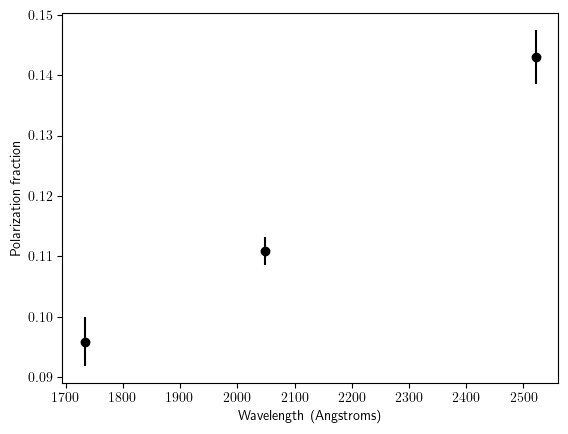

In [47]:
mod_p_show = dict()
for mname in xopt_all.keys():
    if xopt_all[mname].fun < 1.:
        mod_p_show[mname] = mod_p_all[mname]
pol_plot(mod_p_show, spec, pol_model, show_legend=False)

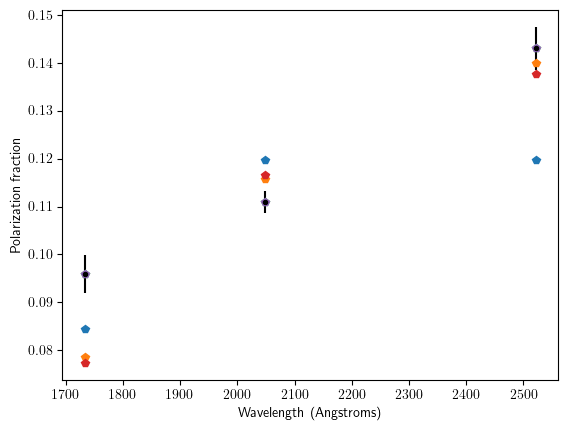

In [48]:
mod_p_gas = dict()
for mname in xopt_all.keys():
    if mname[:2]=="GG":
        mod_p_gas[mname] = mod_p_all[mname]
pol_plot(mod_p_gas, spec, pol_model, show_legend=False, fmt='k.')

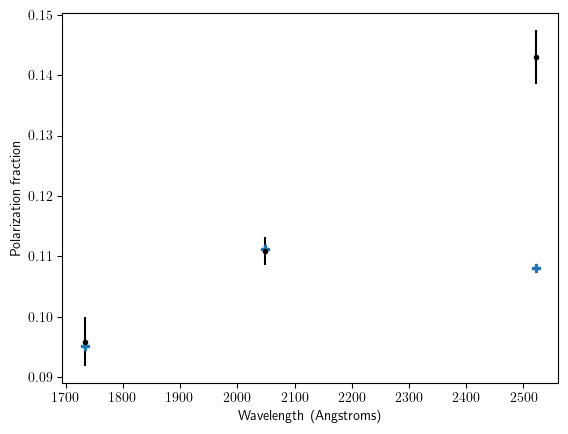

In [64]:
mod_p_dust = dict()
for mname in xopt_all.keys():
    if mname[:2]!="GG" and xopt_all[mname].fun < 70.:
        mod_p_dust[mname] = mod_p_all[mname]
pol_plot(mod_p_dust, spec, pol_model, show_legend=False, fmt='k.')